In [19]:
import os
from datetime import datetime, timezone
import pandas as pd
import asyncio
from cybotrade_datasource import cybotrade_datasource  # Import the module


API_KEY = os.environ.get("API_KEY", "8JtZNJ70irCpyXkW3AeLwrIwrWP8a7Yxgsq4hkb3MVR2GPOm")  # Replace with your actual key if not using env var

async def main():
    data = await cybotrade_datasource.query_paginated(
        api_key=API_KEY,
        topic='cryptoquant|btc/inter-entity-flows/miner-to-miner?from_miner=f2pool&to_miner=all_miner&window=hour',
        start_time=datetime(year=2024, month=1, day=1, tzinfo=timezone.utc),
        end_time=datetime(year=2025, month=1, day=1, tzinfo=timezone.utc)
    )
    df = pd.DataFrame(data)
    print(df)
    return df

# For Jupyter notebook:
await main()

         start_time             datetime  flow_mean  flow_total  \
0     1704067200000  2024-01-01 00:00:00   0.029870    0.179217   
1     1704070800000  2024-01-01 01:00:00   0.002678    0.016070   
2     1704074400000  2024-01-01 02:00:00   1.429114   10.003799   
3     1704078000000  2024-01-01 03:00:00   0.028992    0.231934   
4     1704081600000  2024-01-01 04:00:00   0.014172    0.056689   
...             ...                  ...        ...         ...   
8779  1735671600000  2024-12-31 19:00:00   0.010585    0.063512   
8780  1735675200000  2024-12-31 20:00:00   0.001900    0.041806   
8781  1735678800000  2024-12-31 21:00:00   0.006088    0.030442   
8782  1735682400000  2024-12-31 22:00:00   0.002222    0.013335   
8783  1735686000000  2024-12-31 23:00:00   0.000054    0.000490   

     transactions_count_flow  
0                          6  
1                          6  
2                          7  
3                          8  
4                          4  
...      

,start_time,datetime,flow_mean,flow_total,transactions_count_flow
0,1704067200000,2024-01-01 00:00:00,0.029870,0.179217,6
1,1704070800000,2024-01-01 01:00:00,0.002678,0.016070,6
2,1704074400000,2024-01-01 02:00:00,1.429114,10.003799,7
3,1704078000000,2024-01-01 03:00:00,0.028992,0.231934,8
4,1704081600000,2024-01-01 04:00:00,0.014172,0.056689,4
...,...,...,...,...,...
8779,1735671600000,2024-12-31 19:00:00,0.010585,0.063512,6
8780,1735675200000,2024-12-31 20:00:00,0.001900,0.041806,22
8781,1735678800000,2024-12-31 21:00:00,0.006088,0.030442,5
8782,1735682400000,2024-12-31 22:00:00,0.002222,0.013335,6


In [20]:
import requests
import pandas as pd
import json
from datetime import datetime

class CyboTradeDataClient:
    def __init__(self, api_keys=None):
        self.base_paths = {
            "coinglass": "https://api.datasource.cybotrade.rs/coinglass"
        }
        
        self.api_keys = api_keys or {
            "coinglass": "8JtZNJ70irCpyXkW3AeLwrIwrWP8a7Yxgsq4hkb3MVR2GPOm",
        }
    
    def fetch_coinglass_orderbook(self, exchange="Binance", symbol="BTCUSDT", 
                                 interval="1h", start_time="20191001T100000", limit=1000):
        """Fetch orderbook history data from CoinGlass"""
        url = f"{self.base_paths['coinglass']}/spot/orderbook/history"
        
        params = {
            "exchange": exchange,
            "symbol": symbol,
            "interval": interval,
            "start_time": start_time,
            "limit": limit
        }
        
        headers = {
            "X-API-Key": self.api_keys["coinglass"]
        }
        
        print(f"Fetching orderbook data for {symbol} on {exchange}...")
        try:
            response = requests.get(url, params=params, headers=headers)
            
            if response.status_code == 200:
                data = response.json()
                print(f"Successfully received response")
                return data
            else:
                print(f"Error: {response.status_code} {response.reason} for url: {response.url}")
                print(response.text)
                return None
        except Exception as e:
            print(f"Exception occurred while fetching orderbook data: {e}")
            return None

# Create client instance
client = CyboTradeDataClient()

# Fetch data with some parameters
data = client.fetch_coinglass_orderbook(
    exchange="Binance",
    symbol="BTCUSDT",
    interval="1h",
    start_time="20240101T000000",
    limit=100
)

# Examine the structure of the data before trying to convert
if data:
    print("\nData type:", type(data))
    
    # Print a sample of the data to understand its structure
    print("\nData structure sample:")
    print(json.dumps(data if isinstance(data, dict) else data[0] if isinstance(data, list) and data else data, indent=2)[:500] + "...")
    
    # Handle different potential data structures
    try:
        if isinstance(data, list):
            # If it's a list of records
            df = pd.DataFrame(data)
        elif isinstance(data, dict):
            if 'data' in data or 'records' in data or 'results' in data:
                # Common API response pattern - data inside a nested field
                data_field = data.get('data') or data.get('records') or data.get('results')
                if isinstance(data_field, list):
                    df = pd.DataFrame(data_field)
                else:
                    print("Nested data field is not a list, trying to create DataFrame from the entire dict")
                    df = pd.DataFrame([data])  # Wrap the dictionary in a list
            else:
                # Try to normalize the structure
                print("Attempting to normalize and create DataFrame from dict")
                df = pd.json_normalize(data)
        else:
            print(f"Unexpected data type: {type(data)}")
            df = None
            
        if df is not None:
            print("\nDataFrame Information:")
            print(f"Shape: {df.shape}")
            print("\nColumns:", df.columns.tolist())
            
            # Display the first few rows
            print("\nFirst 5 rows:")
            display(df.head())
            
    except Exception as e:
        print(f"Error creating DataFrame: {e}")
        print("This might require custom parsing based on the data structure")
else:
    print("No data to convert to DataFrame")

Fetching orderbook data for BTCUSDT on Binance...
Successfully received response

Data type: <class 'dict'>

Data structure sample:
{
  "data": [
    {
      "start_time": 1743890400000,
      "asksAmount": 169.43344,
      "asksRate": 0.3817,
      "asksUsd": 14090790.8655,
      "bidsAmount": 276.19316,
      "bidsRate": 0.6183,
      "bidsUsd": 22822615.1933,
      "time": 1743890400
    },
    {
      "start_time": 1743894000000,
      "asksAmount": 257.28025,
      "asksRate": 0.5019,
      "asksUsd": 21464963.8187,
      "bidsAmount": 256.90849,
      "bidsRate": 0.4981,
      "bidsUsd": 21301520.4368,
      "time": 17...

DataFrame Information:
Shape: (100, 8)

Columns: ['start_time', 'asksAmount', 'asksRate', 'asksUsd', 'bidsAmount', 'bidsRate', 'bidsUsd', 'time']

First 5 rows:


,start_time,asksAmount,asksRate,asksUsd,bidsAmount,bidsRate,bidsUsd,time
0,1743890400000,169.43344,0.3817,1.409079e+07,276.19316,0.6183,2.282262e+07,1743890400
1,1743894000000,257.28025,0.5019,2.146496e+07,256.90849,0.4981,2.130152e+07,1743894000
2,1743897600000,207.55194,0.5804,1.741169e+07,150.92469,0.4196,1.258574e+07,1743897600
3,1743901200000,260.16941,0.5362,2.179308e+07,226.15288,0.4638,1.885050e+07,1743901200
4,1743904800000,243.98995,0.5344,2.041823e+07,213.63545,0.4656,1.779116e+07,1743904800


In [21]:
import requests
import pandas as pd
import time

def get_binance_ohlcv(symbol="BTCUSDT", interval="1h", limit=1000, start_time=None, end_time=None):
    
    url = "https://api.binance.com/api/v3/klines"
    params = {
        "symbol": symbol,
        "interval": interval,
        "limit": limit
    }
    if start_time:
        params["startTime"] = start_time
    if end_time:
        params["endTime"] = end_time

    response = requests.get(url, params=params)
    data = response.json()

    df = pd.DataFrame(data, columns=[
        "open_time", "open", "high", "low", "close", "volume",
        "close_time", "quote_asset_volume", "num_trades",
        "taker_buy_base_volume", "taker_buy_quote_volume", "ignore"
    ])

    # Convert timestamp and numeric columns
    df["datetime"] = pd.to_datetime(df["open_time"], unit='ms')
    df[["open", "high", "low", "close", "volume"]] = df[["open", "high", "low", "close", "volume"]].astype(float)
    return df[["datetime", "open", "high", "low", "close", "volume"]]

# Example: Get latest 1000 hourly candles
df_price = get_binance_ohlcv()
print(df_price.head())


             datetime      open      high       low     close      volume
0 2025-02-27 12:00:00  86698.60  86795.90  86252.53  86330.59   997.71723
1 2025-02-27 13:00:00  86330.59  86769.93  85778.98  86117.57  1960.01107
2 2025-02-27 14:00:00  86117.57  86411.76  84951.51  84968.65  4500.81704
3 2025-02-27 15:00:00  84969.99  86145.52  84640.75  85500.84  4924.24541
4 2025-02-27 16:00:00  85500.84  85691.51  84355.04  84471.69  1998.80556


Fetching funding rates for BTCUSDT from Binance...
URL: https://fapi.binance.com/fapi/v1/fundingRate
Parameters: {'symbol': 'BTCUSDT', 'limit': 1000}
Successfully received 1000 records

DataFrame shape: (1000, 4)
Columns: ['symbol', 'fundingTime', 'fundingRate', 'markPrice']
Date range: 2024-05-12 00:00:00 to 2025-04-10 00:00:00

First 5 rows:


,symbol,fundingTime,fundingRate,markPrice
0,BTCUSDT,2024-05-12 00:00:00.000,0.000026,60809.20000000
1,BTCUSDT,2024-05-12 08:00:00.000,0.000028,60804.40000000
2,BTCUSDT,2024-05-12 16:00:00.000,0.000100,61395.90000000
3,BTCUSDT,2024-05-13 00:00:00.001,0.000100,61455.70000000
4,BTCUSDT,2024-05-13 08:00:00.001,0.000085,62307.64358156



Funding Rate Statistics:
Mean funding rate: 0.00006795
Max funding rate: 0.00072446
Min funding rate: -0.00011235


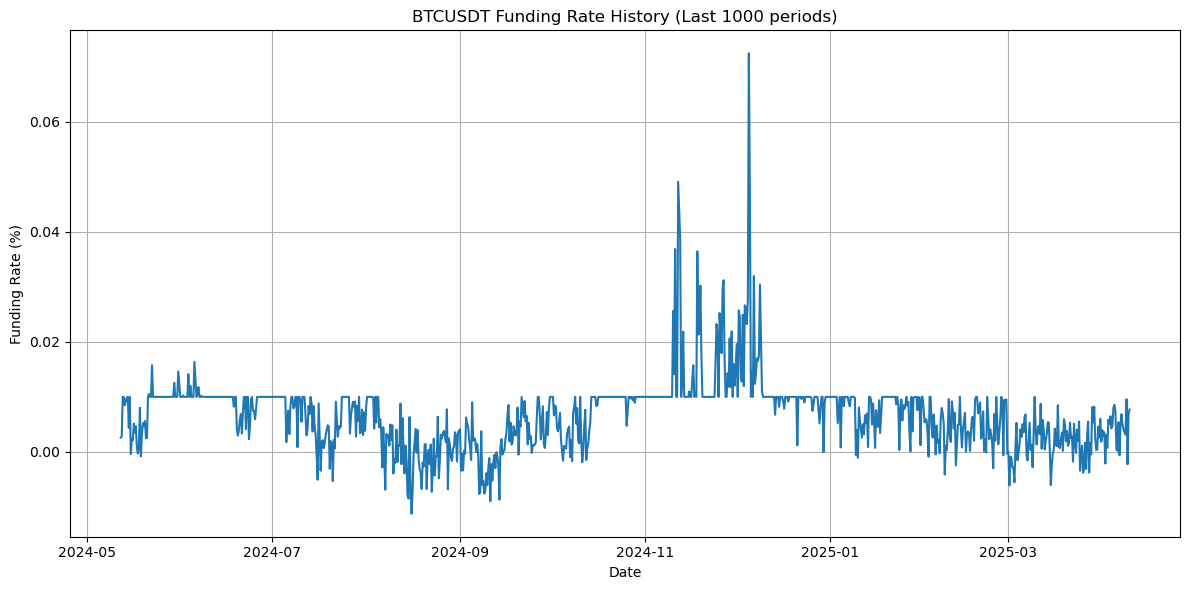

In [31]:
import requests
import pandas as pd
import json
from datetime import datetime

def fetch_binance_funding_rates(symbol="BTCUSDT", interval="1h", limit=1000, start_time=None, end_time=None):

    url = "https://fapi.binance.com/fapi/v1/fundingRate"
    
    # Initialize parameters with required values
    params = {
        "symbol": symbol,
        "limit": limit
    }
    
    # Add optional time parameters if provided
    if start_time is not None:
        params["startTime"] = start_time
    if end_time is not None:
        params["endTime"] = end_time
    
    print(f"Fetching funding rates for {symbol} from Binance...")
    print(f"URL: {url}")
    print(f"Parameters: {params}")
    
    try:
        response = requests.get(url, params=params)
        
        if response.status_code == 200:
            data = response.json()
            print(f"Successfully received {len(data)} records")
            
            # Convert to DataFrame
            df = pd.DataFrame(data)
            
            # Convert timestamp to datetime
            if 'fundingTime' in df.columns:
                df['fundingTime'] = pd.to_datetime(df['fundingTime'], unit='ms')
            
            # Convert rate to numeric
            if 'fundingRate' in df.columns:
                df['fundingRate'] = pd.to_numeric(df['fundingRate'])
            
            # Display information about the DataFrame
            print(f"\nDataFrame shape: {df.shape}")
            print(f"Columns: {df.columns.tolist()}")
            print(f"Date range: {df['fundingTime'].min()} to {df['fundingTime'].max()}")
            
            return df
        else:
            print(f"Error: {response.status_code} {response.reason}")
            print(f"Response: {response.text}")
            return None
    except Exception as e:
        print(f"Exception occurred: {e}")
        return None

# Fetch funding rate data for BTCUSDT
btc_funding_rates = fetch_binance_funding_rates(
    symbol="BTCUSDT",
    limit=1000
)

if btc_funding_rates is not None:
    # Display the first few rows
    print("\nFirst 5 rows:")
    display(btc_funding_rates.head())
    
    # Optional: Calculate some statistics
    stats = {
        "Mean funding rate": btc_funding_rates['fundingRate'].mean(),
        "Max funding rate": btc_funding_rates['fundingRate'].max(),
        "Min funding rate": btc_funding_rates['fundingRate'].min()
    }
    
    print("\nFunding Rate Statistics:")
    for stat, value in stats.items():
        print(f"{stat}: {value:.8f}")
    
    # Optional: Save to CSV
    # btc_funding_rates.to_csv("binance_btc_funding_rates.csv", index=False)
    
    # Plot the funding rate over time
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(12, 6))
        plt.plot(btc_funding_rates['fundingTime'], btc_funding_rates['fundingRate'] * 100)  # Convert to percentage
        plt.title(f'BTCUSDT Funding Rate History (Last {len(btc_funding_rates)} periods)')
        plt.xlabel('Date')
        plt.ylabel('Funding Rate (%)')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error creating plot: {e}")

In [15]:
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import numpy as np
from textblob import TextBlob

def fetch_sentiment_data(start_date=None, end_date=None, interval='1h'):

    #(2 years to stay within yfinance 730-day limit for hourly data)
    if end_date is None:
        end_date = datetime(2025, 4, 12)
    else:
        end_date = datetime.strptime(end_date, '%Y-%m-%d')
    if start_date is None:
        start_date = end_date - timedelta(days=2*365)  # 2 years
    else:
        start_date = datetime.strptime(start_date, '%Y-%m-%d')
    
    # Ensure start_date is within 730 days from end_date
    max_start = end_date - timedelta(days=730)
    if start_date < max_start:
        print(f"Adjusting start_date to {max_start.date()} to fit yfinance 730-day limit")
        start_date = max_start
    
    try:
        df = yf.download('BTC-USD', start=start_date, end=end_date, interval='1d')
        
        if df.empty:
            print("No data returned from yfinance. Check ticker or date range.")
            return None
        

        df = df[['Close']].resample('1h').ffill()
        
        # Calculate returns
        df['Returns'] = df['Close'].pct_change().fillna(0)
        
        np.random.seed(42)
        df['Text'] = np.random.choice(
            ['Bullish crypto market!', 'Bearish sentiment detected.', 'Neutral news.'],
            len(df)
        )
        
        # Add sentiment using TextBlob (free, local)
        df['Sentiment'] = df['Text'].apply(lambda x: TextBlob(x).sentiment.polarity)
        
        return df
    
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

# Example usage
if __name__ == "__main__":
    df = fetch_sentiment_data(interval='1h')
    if df is not None:
        print(df.head())
        print(f"Data shape: {df.shape}")

[*********************100%***********************]  1 of 1 completed


Price                       Close Returns                    Text Sentiment
Ticker                    BTC-USD                                          
Date                                                                       
2023-04-13 00:00:00  30399.066406     0.0           Neutral news.       0.0
2023-04-13 01:00:00  30399.066406     0.0  Bullish crypto market!       0.0
2023-04-13 02:00:00  30399.066406     0.0           Neutral news.       0.0
2023-04-13 03:00:00  30399.066406     0.0           Neutral news.       0.0
2023-04-13 04:00:00  30399.066406     0.0  Bullish crypto market!       0.0
Data shape: (17497, 4)
